In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('dataset/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels (0: abnormal, 1: normal)
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=0
)

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

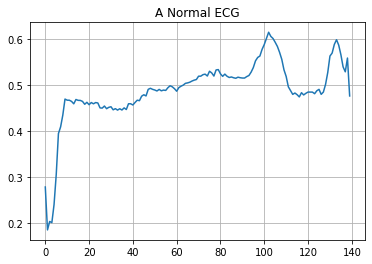

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

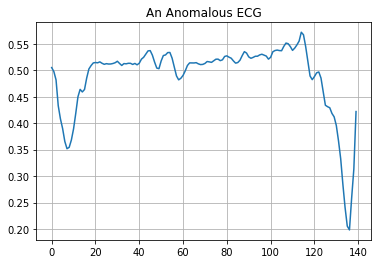

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=1024,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/20
3/3 [==============================] - 0s 36ms/step - loss: 0.0458 - val_loss: 0.0437
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0445 - val_loss: 0.0428
Epoch 3/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0422
Epoch 4/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0417 - val_loss: 0.0413
Epoch 5/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0404
Epoch 6/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0388 - val_loss: 0.0398
Epoch 7/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0391
Epoch 8/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0382
Epoch 9/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.0377
Epoch 10/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0327 - val_loss: 0.0371
Epoch 11/20
3/3 [=====================

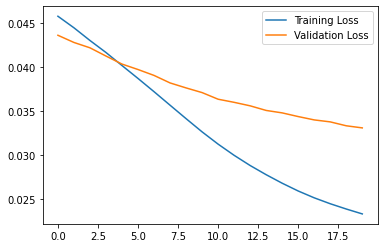

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

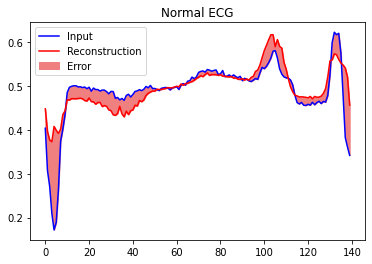

In [11]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Normal ECG")
plt.show()

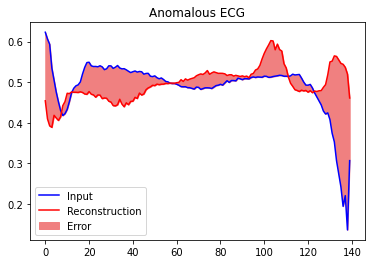

In [12]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title("Anomalous ECG")
plt.show()

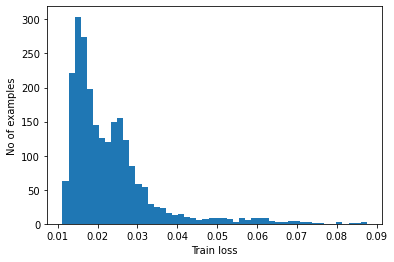

In [13]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.MAE(reconstructions, normal_train_data.numpy())

plt.figure()
plt.hist(train_loss.numpy(), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033696093


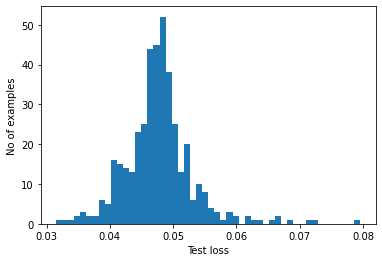

In [15]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss.numpy(), bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [17]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.939
Precision = 0.9943502824858758
Recall = 0.9010238907849829


In [18]:
model_version = "0001"
model_dir = "../../saved_models"
model_name = "anomaly_autoencoder_model"
model_path = os.path.join(model_dir, model_name, model_version)
tf.saved_model.save(autoencoder, model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../saved_models/anomaly_autoencoder_model/0001/assets
